In [2]:
# From regression.csv, generate a filtered valueble version.
# 1. For each buggy commit, search them in all the files, 

Severity raised: 16
Severity decreased: 19
Severity unchanged: 102
Severity not found: 32


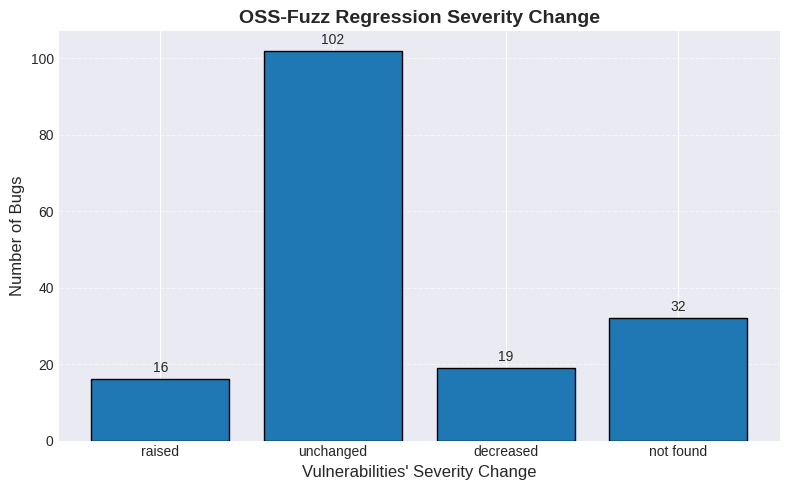

In [3]:
# severity change from ossfuzz
import os
import pandas as pd
import yaml

csvpath = "regression.csv"
if not os.path.exists(csvpath):
    raise FileNotFoundError(f"{csvpath} invalid")

# Read the CSV file
df = pd.read_csv(csvpath) # repo,buggy_fix,fix0_file,fix1_file

def extract_severity(yaml_file):
    try:
        with open(yaml_file, 'r') as file:
            data = yaml.full_load(file)
            affected = data.get('affected', [])
            for entry in affected:
                severity = entry.get('ecosystem_specific', {}).get('severity', "")
                if severity:
                    return severity.lower() 
    except Exception as e:
        print(f"Error reading {yaml_file}: {e}")
    return None

# Compare the severity of the two files
severity_raise_cnt = 0
severity_decrease_cnt = 0
severity_unchanged_cnt = 0
severity_not_found_cnt = 0
for _, row in df.iterrows():
    fix0_severity = extract_severity(row['fix0_file'])
    fix1_severity = extract_severity(row['fix1_file'])

    # define the severity levels
    severity_levels = {
        "low": 1,
        "medium": 2,
        "high": 3,
        "critical": 4
    }
    # compare the severity levels
    if fix0_severity and fix1_severity:
        if severity_levels[fix0_severity] < severity_levels[fix1_severity]:
            severity_raise_cnt += 1
        elif severity_levels[fix0_severity] > severity_levels[fix1_severity]:
            severity_decrease_cnt += 1
        elif severity_levels[fix0_severity] == severity_levels[fix1_severity]:
            severity_unchanged_cnt += 1
    else:
        # print(f"Severity not found for {row['fix0_file']} or {row['fix1_file']}")
        severity_not_found_cnt += 1                                     

# print the results
print(f"Severity raised: {severity_raise_cnt}")
print(f"Severity decreased: {severity_decrease_cnt}")
print(f"Severity unchanged: {severity_unchanged_cnt}")
print(f"Severity not found: {severity_not_found_cnt}")

import matplotlib.pyplot as plt
# Set style
plt.style.use('seaborn-v0_8-darkgrid')  

# Data for plotting
labels = ['raised', 'unchanged', 'decreased', 'not found']
sizes = [severity_raise_cnt, severity_unchanged_cnt, severity_decrease_cnt, severity_not_found_cnt] 

# Plotting
fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(labels, sizes, edgecolor='black')

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # offset
                textcoords="offset points",
                ha='center', va='bottom', fontsize=10)

# Title and labels
ax.set_title('OSS-Fuzz Regression Severity Change', fontsize=14, fontweight='bold')
ax.set_xlabel("Vulnerabilities' Severity Change", fontsize=12)
ax.set_ylabel('Number of Bugs', fontsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.6)

# Improve layout
plt.tight_layout()
plt.show()


           Bug type before                                   Bug type after  Count
      heap-buffer-overflow                             heap-buffer-overflow     50
use-of-uninitialized-value                       use-of-uninitialized-value     12
              unknown read                                     unknown read      9
       heap-use-after-free                              heap-use-after-free      8
     stack-buffer-overflow                            stack-buffer-overflow      8
       heap-use-after-free                             heap-buffer-overflow      6
      heap-buffer-overflow                              heap-use-after-free      5
              unknown read                             heap-buffer-overflow      5
    global-buffer-overflow                           global-buffer-overflow      4
use-of-uninitialized-value                             heap-buffer-overflow      4
      heap-buffer-overflow                                     unknown read      4
    

/tmp/ipykernel_674843/1722527970.py:73: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(bug0_list))


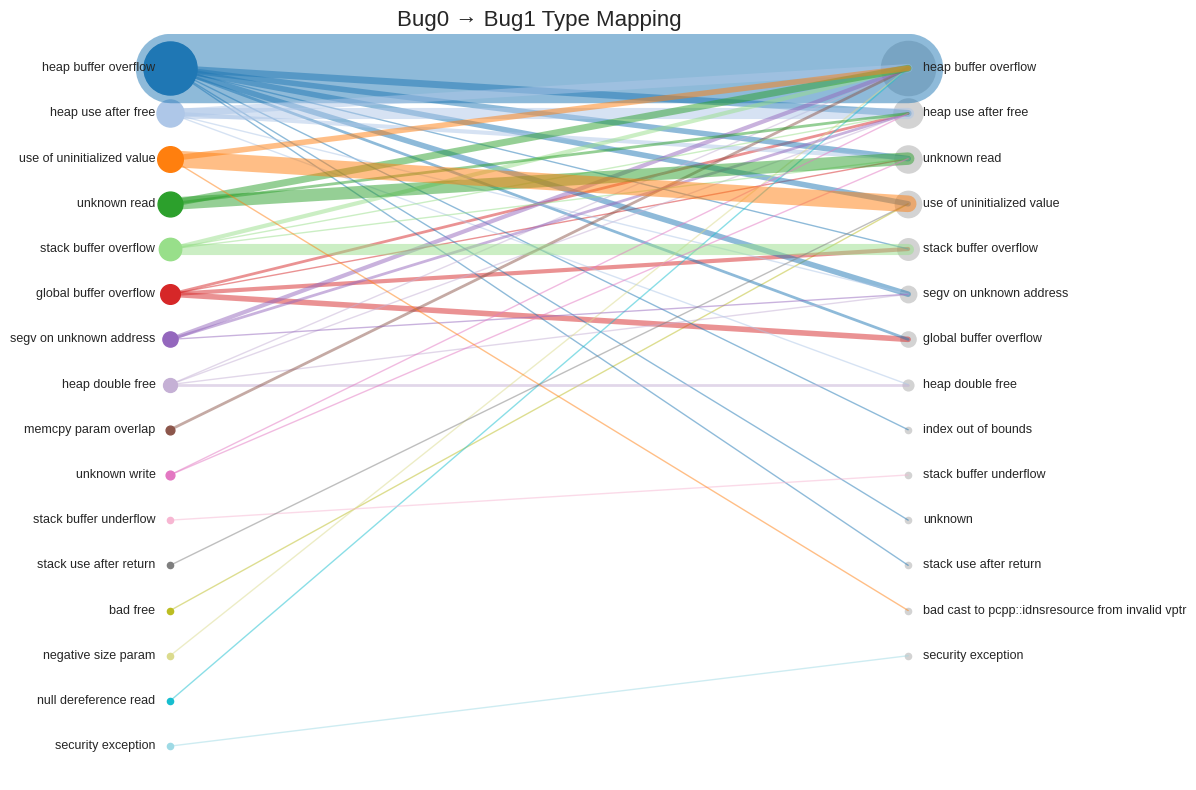

heap buffer overflow -> heap buffer overflow: 50
heap buffer overflow -> heap use after free: 5
heap buffer overflow -> unknown read: 4
heap buffer overflow -> use of uninitialized value: 4
heap buffer overflow -> stack buffer overflow: 1
heap buffer overflow -> segv on unknown address: 4
heap buffer overflow -> global buffer overflow: 2
heap buffer overflow -> index out of bounds: 1
heap buffer overflow -> unknown: 1
heap buffer overflow -> stack use after return: 1
heap use after free -> heap buffer overflow: 6
heap use after free -> heap use after free: 8
heap use after free -> unknown read: 3
heap use after free -> segv on unknown address: 1
heap use after free -> heap double free: 1
use of uninitialized value -> heap buffer overflow: 4
use of uninitialized value -> use of uninitialized value: 12
use of uninitialized value -> bad cast to pcpp::idnsresource from invalid vptr: 1
unknown read -> heap buffer overflow: 5
unknown read -> heap use after free: 2
unknown read -> unknown rea

In [7]:
from collections import Counter

from matplotlib import cm

# map bug types before and after regression
def extract_bug_type(yaml_file):
    try:
        with open(yaml_file, 'r') as file:
            data = yaml.full_load(file)
            summary = data.get('summary', []) # summary: Heap-buffer-overflow in op_Const64, I need the part before 'in'
            if isinstance(summary, str):
                # Extract the part before 'in'
                bug_type = summary.split(' in ')[0] if ' in ' in summary else summary
                return bug_type.lower()
    except Exception as e:
        print(f"Error reading {yaml_file}: {e}")
    return None

csvpath = "regression.csv"
if not os.path.exists(csvpath):
    raise FileNotFoundError(f"{csvpath} invalid")

# Read the CSV file
df = pd.read_csv(csvpath) # repo,buggy_fix,fix0_file,fix1_file

bug_type_transitions = Counter()

for _,item in df.iterrows():
    bug0_type = extract_bug_type(item['fix0_file'])
    bug1_type = extract_bug_type(item['fix1_file'])
    if bug0_type and bug1_type:
        bug_type_transitions[(bug0_type, bug1_type)] += 1

transition_df = pd.DataFrame(
    [(*k, v) for k, v in bug_type_transitions.items()],
    columns=["Bug type before", "Bug type after", "Count"]
)

transition_df = transition_df.sort_values(by="Count", ascending=False).reset_index(drop=True)
print(transition_df.to_string(index=False))


# Plotting the bug type transitions
def generate_map():
    csv_path = 'regression.csv'
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"{csv_path} invalid")
    
    df = pd.read_csv(csv_path)

    df['bug0_types'] = df['fix0_file'].apply(extract_bug_type)
    df['bug1_types'] = df['fix1_file'].apply(extract_bug_type)
    df = df.dropna(subset=['bug0_types', 'bug1_types'])
    df['bug0_types'] = df['bug0_types'].str.replace('-', ' ')
    df['bug1_types'] = df['bug1_types'].str.replace('-', ' ')

    edge_counts = (
        df
        .groupby(['bug0_types', 'bug1_types'])
        .size()
        .reset_index(name='count')
    )

    bug0_counts = df['bug0_types'].value_counts()
    bug1_counts = df['bug1_types'].value_counts()

    bug0_list = list(bug0_counts.index)
    bug1_list = list(bug1_counts.index)

    pos0 = {bug: (0, i) for i, bug in enumerate(bug0_list)}
    pos1 = {bug: (1, i) for i, bug in enumerate(bug1_list)}
        
    cmap = cm.get_cmap('tab20', len(bug0_list))  
    colors = {bug: cmap(i) for i, bug in enumerate(bug0_list)}

    plt.figure(figsize=(12, max(len(bug0_list), len(bug1_list)) * 0.5))
    ax = plt.gca()

    for _, row in edge_counts.iterrows():
        bug0 = row['bug0_types']
        bug1 = row['bug1_types']
        x0, y0 = pos0[bug0]
        x1, y1 = pos1[bug1]
        ax.plot([x0, x1], [y0, y1],
                linewidth=row['count'],
                alpha=0.5,
                color=colors[bug0])

    for bug, cnt in bug0_counts.items():
        x, y = pos0[bug]
        ax.scatter(x, y, s=cnt * 20, color=colors[bug])

    for bug, cnt in bug1_counts.items():
        x, y = pos1[bug]
        ax.scatter(x, y, s=cnt * 20, color='lightgray')

    for bug in bug0_list:
        x, y = pos0[bug]
        ax.text(x - 0.02, y, bug, ha='right', va='center', fontsize=9)

    for bug in bug1_list:
        x, y = pos1[bug]
        ax.text(x + 0.02, y, bug, ha='left', va='center', fontsize=9)

    ax.invert_yaxis()
    ax.axis('off')
    plt.title('Bug0 → Bug1 Type Mapping', fontsize=16)
    plt.tight_layout()
    plt.show()

    for bug0 in bug0_list:
        for bug1 in bug1_list:
            count = edge_counts.loc[
                (edge_counts['bug0_types'] == bug0) & 
                (edge_counts['bug1_types'] == bug1), 'count'
            ]
            if not count.empty:
                print(f"{bug0} -> {bug1}: {count.values[0]}")

generate_map()

# calculate how many bug types stay the same

def calculate_same_bug_type():
    csv_path = 'regression.csv'
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"{csv_path} invalid")
    
    df = pd.read_csv(csv_path)

    df['bug0_types'] = df['fix0_file'].apply(extract_bug_type)
    df['bug1_types'] = df['fix1_file'].apply(extract_bug_type)
    df = df.dropna(subset=['bug0_types', 'bug1_types'])
    df['bug0_types'] = df['bug0_types'].str.replace('-', ' ')
    df['bug1_types'] = df['bug1_types'].str.replace('-', ' ')

    same_bug_type_count = (df['bug0_types'] == df['bug1_types']).sum()
    total_count = len(df)

    print(f"Same bug type count: {same_bug_type_count}")
    print(f"Total count: {total_count}")
    print(f"Percentage of same bug types: {same_bug_type_count / total_count * 100:.2f}%")


calculate_same_bug_type()


/tmp/ipykernel_674843/2844057201.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20c')(range(len(bug0_counts_filtered)))


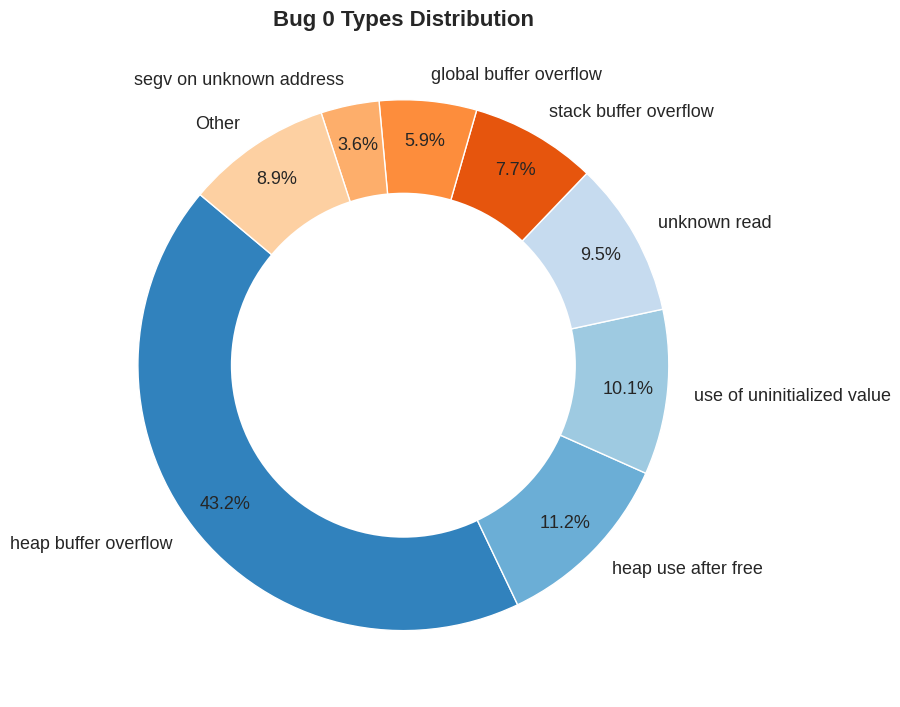

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import os

def calculate_portion():
    csv_path = 'regression.csv'
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"{csv_path} invalid")
    
    df = pd.read_csv(csv_path)
    
    df['bug0_types'] = df['fix0_file'].apply(extract_bug_type)
    df['bug1_types'] = df['fix1_file'].apply(extract_bug_type)
    df = df.dropna(subset=['bug0_types', 'bug1_types'])
    df['bug0_types'] = df['bug0_types'].str.replace('-', ' ')
    df['bug1_types'] = df['bug1_types'].str.replace('-', ' ')

    bug0_counts = df['bug0_types'].value_counts()
    
    # Group small slices into "Other"
    threshold = 0.03  # Group bugs < 3%
    total = bug0_counts.sum()
    bug0_counts_filtered = bug0_counts[bug0_counts / total >= threshold]
    other = bug0_counts[bug0_counts / total < threshold].sum()
    if other > 0:
        bug0_counts_filtered['Other'] = other

    colors = plt.cm.get_cmap('tab20c')(range(len(bug0_counts_filtered)))

    fig, ax = plt.subplots(figsize=(9, 9))
    wedges, texts, autotexts = ax.pie(
        bug0_counts_filtered,
        labels=bug0_counts_filtered.index,
        autopct='%1.1f%%',
        startangle=140,
        colors=colors,
        wedgeprops={'edgecolor': 'white'},
        textprops={'fontsize': 13},
        pctdistance=0.85
    )

    # Draw white circle in the middle to make a donut chart
    centre_circle = plt.Circle((0, 0), 0.65, fc='white')
    fig.gca().add_artist(centre_circle)

    ax.set_title('Bug 0 Types Distribution', fontsize=16, weight='bold')
    plt.tight_layout()
    plt.show()

calculate_portion()
